In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import xcoll.geometry.trajectories as tr
import xcoll.geometry.segments as seg
import xcoll.geometry.c_init as box


# %matplotlib ipympl
%matplotlib tk


# Bounding Box Tests

In [ ]:
sintC = np.sin(np.deg2rad(45))
cosTC = np.cos(np.deg2rad(45))
rC = 2
sin_tb = np.sin(0.)
cos_tb = np.cos(0)
projL = rC*(cos_tb*cosTC + sin_tb*sintC)
projW = rC*(cos_tb*sintC - sin_tb*cosTC) 
b1 = box.BoundingBox(rC=rC, sin_tC=sintC, cos_tC=cosTC, sin_tb=sin_tb, cos_tb=cos_tb, l=2,w=2, proj_l=projL, proj_w=projW)



In [ ]:
L = seg.LineSegment(s1=0, x1=1, s2
                    =4, x2=3)

In [ ]:
LL.T

In [ ]:
LL = np.array(b1.vertices)
new = np.vstack([LL, LL[0]])
print(LL.T)
print(new.T)
plt.plot(new.T[0], new.T[1], color='red')

In [ ]:
vertices = np.array([L.box.vertices])
new = np.append((vertices, np.array([vertices[0]])))
print(new)
print(L.box.l)
print(L.box.cos_tb)
print(L.box.sin_tb)

In [ ]:
plt.figure(1)
plt.plot(*np.array([L]).T)
plt.show()

In [ ]:
sintC = np.sin(np.deg2rad(11.309932))
cosTC = np.cos(np.deg2rad(11.309932))
rC = 5.099
sin_b = np.sin(np.deg2rad(45))
cos_b = np.cos(np.deg2rad(45))
projL = rC*(cos_b*cosTC + sin_b*sintC)
projW = rC*(cos_b*sintC - sin_b*cosTC) 
b2 = box.BoundingBox(rC=rC, sin_tC=sintC, cos_tC=cosTC, sin_tb=sin_b, cos_tb=cos_b, l=2.8284271247462,w=2.8284271247462, proj_l=projL, proj_w=projW)

In [ ]:
sintC = np.sin(np.deg2rad(0.))
cosTC = np.cos(np.deg2rad(0.))
rC = 5.
sin_b = np.sin(np.deg2rad(45.))
cos_b = np.cos(np.deg2rad(45.))
projL = rC*(cos_b*cosTC + sin_b*sintC)
projW = rC*(cos_b*sintC - sin_b*cosTC) 
b3 = box.BoundingBox(rC=rC, sin_tC=sintC, cos_tC=cosTC, sin_tb=sin_b, cos_tb=cos_b, l=2.8284271247462,w=1.4142135623731, proj_l=projL, proj_w=projW)

In [ ]:
overlap1 = b1.overlaps(b2=b2)  # this should overlap
overlap2 = b1.overlaps(b2=b3)  # this should not overlap
overlap3 = b2.overlaps(b2=b3)  # this should overlap

print(f"Overlap1: {overlap1}")
print(f"Overlap2: {overlap2}")
print(f"Overlap3: {overlap3}")

In [ ]:
np.max([1,2])

In [3]:
def test_BoundingBox_segment(segtype='line', **kwargs):
    if segtype == 'line':
        s1, x1, s2, x2 = kwargs['s1'], kwargs['x1'], kwargs['s2'], kwargs['x2']
        t1, t2 = kwargs.pop('t1', 0), kwargs.pop('t2', 1)
        L = seg.LineSegment(s1=s1,x1=x1,s2=s2,x2=x2)
        l = np.sqrt((s2 - s1)*(s2 - s1) + (x2 - x1)*(x2 - x1))
        w = L.box.l/3.
    elif segtype == 'halfopen':
        s1, x1, theta = kwargs['s1'], kwargs['x1'], kwargs['theta']
        L = seg.HalfOpenLineSegment(s1=s1,x1=x1,theta1=theta)
        t1, t2 = kwargs.pop('t1', 0), kwargs.pop('t2', 10)
        s2 = s1 + t2*np.cos(theta)
        x2 = x1 + t2*np.sin(theta)
        l = np.sqrt((s2 - s1)*(s2 - s1) + (x2 - x1)*(x2 - x1))
        w = L.box.l/3.
    elif segtype == 'circular':
        print("You can expect error at rC, projL and projW and cos/sin tC")
        R, sR, xR, theta1, theta2 = kwargs['R'], kwargs['sR'], kwargs['xR'], kwargs['theta1'], kwargs['theta2']
        L = seg.CircularSegment(R=R,sR=sR,xR=xR,theta1=theta1,theta2=theta2)
        t1, t2 = kwargs.pop('t1', 0), kwargs.pop('t2', 2*np.pi)
        x1 = xR + R*np.sin(theta1 + t1*(theta2 - theta1))
        s1 = sR + R*np.cos(theta1 + t1*(theta2 - theta1))
        x2 = xR + R*np.sin(theta1 + t2*(theta2 - theta1))
        s2 = sR + R*np.cos(theta1 + t2*(theta2 - theta1))
        print(f"Calculated: {s1}, {x1}, {s2}, {x2}")
        l = np.sqrt((s2 - s1)*(s2 - s1) + (x2 - x1)*(x2 - x1))
        w = R - np.sqrt(R*R - L.box.l*L.box.l/4.)
        rC = 1
        projL = 0. 
        projW = 0.

    elif segtype == 'bezier':
        s1, x1, cs1, cx1, cs2, cx2, s2, x2 = kwargs['s1'], kwargs['x1'], kwargs['cs1'], kwargs['cx1'], kwargs['cs2'], kwargs['cx2'], kwargs['s2'], kwargs['x2']
        L = seg.BezierSegment(s1=s1,x1=x1,cs1=cs1,cx1=cx1,cs2=cs2,cx2=cx2,s2=s2,x2=x2)
        t1, t2 = kwargs.pop('t1', 0), kwargs.pop('t2', 1)
        l = np.max([s1,s2]) - np.min([s1,s2])
        w = np.max([x1,x2]) - np.min([x1,x2])
        rC = np.sqrt(s1*s1 + s2*s2)
        projL = np.min([s1,s2])
        projW = np.min([x1,x2])
        sin_tc  = projW / rC
        cos_tc = projL / rC
        sin_tb = 0
        cos_tb = 1
    else:
        raise ValueError("Invalid segment type")

    if segtype != 'bezier':
        # Calculate sin_t and cos_t
        sin_t = (x2 - x1) / np.sqrt((x2 - x1)**2 + (s2 - s1)**2)
        cos_t = (s2 - s1) / np.sqrt((x2 - x1)**2 + (s2 - s1)**2)

        # Initialize sin_p and cos_p
        sin_p, cos_p = None, None

        # Adjust sin_t and cos_t if theta is larger than 180 degrees
        if sin_t < 0:  # if theta is larger than 180 degrees, theta = theta - 180
            sin_t = -sin_t
            cos_t = -cos_t

        # Determine sin_p and cos_p based on cos_t
        if cos_t < 1:  # if theta is larger than 90 degrees, phi = theta + 90
            sin_p = cos_t
            cos_p = -sin_t
        else:  # if theta is between 0 and 90 degrees, phi = theta - 90
            sin_p = -cos_t
            cos_p = sin_t

        rC =  np.sqrt( (s1+w/2.*cos_p) * (s1+w/2.*cos_p) + 
                    (x1+w/2.*sin_p) * (x1+w/2.*sin_p) )
        cos_tb = cos_t
        sin_tb = sin_t
        cos_tc = s1 / rC
        sin_tc = x1 / rC
        projL = rC*(cos_tb*cos_tc + sin_tb*sin_tc)
        projW = rC*(cos_tb*sin_tc - sin_tb*cos_tc)
    if abs(l - L.box.l) > 1e-9:
        print(f"Alert {segtype}: Length difference exceeds tolerance! Calculated: {l}, Box: {L.box.l}")
    if abs(w - L.box.w) > 1e-9:
        print(f"Alert {segtype}: Width difference exceeds tolerance! Calculated: {w}, Box: {L.box.w}")
    if abs(sin_tc - L.box.sin_tC) > 1e-9:
        print(f"Alert {segtype}: sin_tC difference exceeds tolerance! Calculated: {sin_tc}, Box: {L.box.sin_tC}")
    if abs(cos_tc - L.box.cos_tC) > 1e-9:
        print(f"Alert {segtype}: cos_tC difference exceeds tolerance! Calculated: {cos_tc}, Box: {L.box.cos_tC}")
    if abs(sin_tb - L.box.sin_tb) > 1e-9:
        print(f"Alert {segtype}: sin_tb difference exceeds tolerance! Calculated: {sin_tb}, Box: {L.box.sin_tb}")
    if abs(cos_tb - L.box.cos_tb) > 1e-9:
        print(f"Alert {segtype}: cos_tb difference exceeds tolerance! Calculated: {cos_tb}, Box: {L.box.cos_tb}")
    if abs(projL - L.box.proj_l) > 1e-9:
        print(f"Alert {segtype}: proj_l difference exceeds tolerance! Calculated: {projL}, Box: {L.box.proj_l}")
    if abs(projW - L.box.proj_w) > 1e-9:
        print(f"Alert {segtype}: proj_w difference exceeds tolerance! Calculated: {projW}, Box: {L.box.proj_w}")
    if abs(rC - L.box.rC) > 1e-9:
        print(f"Alert {segtype}: rC difference exceeds tolerance! Calculated: {rC}, Box: {L.box.rC}")
    print()


In [4]:
#test_BoundingBox_segment(segtype='line', s1=0, x1=0, s2=1, x2=1, t1=0, t2=1)
#test_BoundingBox_segment(segtype='halfopen', s1=1, x1=0, theta=np.pi/3, t1=0, t2=10)
test_BoundingBox_segment(segtype='circular', R=1, sR=0, xR=0, theta1=np.pi/6, theta2=np.pi/4)
# test_BoundingBox_segment(segtype='bezier', s1=0, x1=0, cs1=0, cx1=1, cs2=1, cx2=1, s2=1, x2=0, t1=0, t2=1)

You can expect error at rC, projL and projW and cos/sin tC
theta1 0.5235987755982988
theta2 0.7853981633974483
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
tt1 = 0.52359877559829881566, tt2 = 2.16853284244652533275
s1 = 0.866025, s2 = -0.562773
x1 = 0.500000, x2 = 0.826612
Calculated: 0.8660254037844387, 0.49999999999999994, -0.5627728943106137, 0.826611558973896
Alert circular: Length difference exceeds tolerance! Calculated: 1.4656533311444002, Box: 0.319584628167227
Alert circular: Width difference exceeds tolerance! Calculated: 0.012849344649053185, Box: 1.4656533311444002
Alert circular: sin_tC difference exceeds tolerance! Calculated: 0.5021897046842063, Box: 0.49999999999999994
Alert circular: cos_tC difference exceeds tolerance! Calculated: 0.8698180835510557, Box: 0.8660254037844387
Alert circular: sin_tb difference exceeds tolerance! Calculated: 0.2228436643465162, Box: 0.974854194872555
Alert circular: cos_tb difference exceeds tolerance! Calculated: -0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import xcoll.geometry.trajectories as tr

import xcoll.geometry.segments as seg

import xcoll.geometry.c_init as box




# %matplotlib ipympl
#%matplotlib tk

In [ ]:
#L = seg.HalfOpenLineSegment(s1=1,x1=0,cos_t1=np.sqrt(2)/2)
#L.box.l

#L1 = seg.LineSegment(s1=0,x1=0,s2=1,x2=1)
#L1.box.l

#L3 = seg.CircularSegment(R=1,sR=0,xR=0,theta1=np.pi/6,theta2=np.pi/4)

L4 = seg.BezierSegment(s1=0,x1=0,cs1=0.5,cx1=0.5,cs2=0.5,cx2=0.5,s2=1,x2=1) 

In [ ]:
theta_ch = np.arctan2( 0.837257, -0.546810)
theta_b = np.arctan2( 0.546810, 0.837257)
print(np.rad2deg(theta_ch))
print(np.rad2deg(theta_b))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


(<Figure size 800x800 with 1 Axes>, <Axes: xlabel='s', ylabel='x'>)

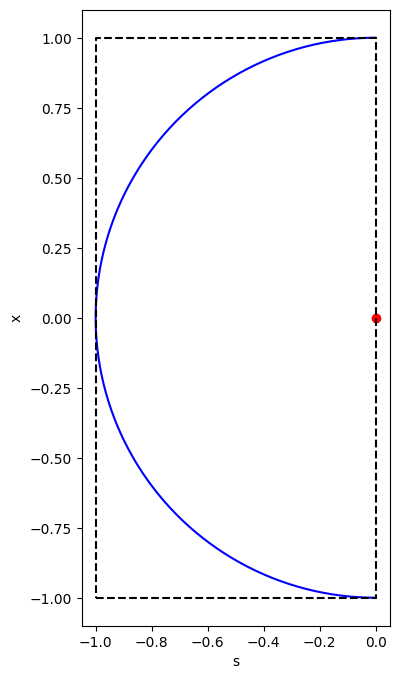

In [2]:
#L = tr.DriftTrajectory(s0=3, x0=3, xp=np.deg2rad(35))
L_circ = tr.CircularTrajectory(R=1, sR=0, xR=0, s0=0, x0=1, l1=0,l2=np.pi)


L_circ.plot(l1=0, l2=np.pi)



In [47]:
ran_1 = np.random.normal()
ran_2 = np.random.normal()

L_mcs = tr.MultipleCoulombTrajectory(s0=0.1, x0=1, xp=np.tan(np.deg2rad(30.)), pc=1e9, beta=1.e9/np.sqrt(0.938e9**2 + 1.e9**2),
                                     q=1, X0=0.0001, ran_1=ran_1, ran_2=ran_2, l1=0,l2=1)


L_mcs.plot()


(<Figure size 800x800 with 1 Axes>, <Axes: xlabel='s', ylabel='x'>)

In [ ]:
S_circ = seg.CircularSegment(R=1,sR=0.4,xR=1.4,theta1=np.pi/6,theta2=3*np.pi/2, t1=0.,t2=1)
S_circ.plot(t1=0, t2=1)

(<Figure size 800x800 with 1 Axes>, <Axes: xlabel='s', ylabel='x'>)

In [48]:
overlap = L_mcs.box.overlaps(b2=S_circ.box)
print(f"Overlap: {overlap}")


Overlap: 1


# Trajectory Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.widgets import Slider
import xcoll.geometry.trajectories as tr
import xcoll.geometry.segments as seg
import xcoll.geometry.c_init as box

#%matplotlib ipympl
%matplotlib tk

In [ ]:
kwargs = {'s0': [-3, 3, 0.1], 'x0': [-3, 3, 0.1], 'theta0': [np.deg2rad(-89), np.deg2rad(89), np.deg2rad(10)]}

tr.DriftTrajectory._inspect(**kwargs)

In [8]:
kwargs = {'sR': [-3, 3, 0.], 'xR': [-3, 3, 0.], 's0': [-2, 2, 1.5], 'x0': [-2, 2, -1.5]}
tr.CircularTrajectory._inspect(**kwargs)

In [2]:
ran_1 = np.random.normal()
ran_2 = np.random.normal()

#fig, _ = tr.MultipleCoulombTrajectory(s0=0.1, x0=1, xp=np.tan(np.deg2rad(30.)), pc=1e9, beta=1.e9/np.sqrt(0.938e9**2 + 1.e9**2),
#                                      q=1, X0=0.0001, ran_1=ran_1, ran_2=ran_2).plot()

kwargs = {'s0': [-3, 3, 0.1], 'x0': [-3, 3, 0.1], 'xp': [np.deg2rad(-180), np.deg2rad(180), np.deg2rad(10)], 'pc':[1e9, 1e9, 1e9],
          'beta': [1.e9/np.sqrt(0.938e9**2 + 1.e9**2), 1.e9/np.sqrt(0.938e9**2 + 1.e9**2), 1.e9/np.sqrt(0.938e9**2 + 1.e9**2)],
          'q': [1, 1, 1], 'X0': [0.0001, 0.001, 0.0001], 'ran_1': [ran_1, ran_1, ran_1], 'ran_2': [ran_2, ran_2, ran_2]}

tr.MultipleCoulombTrajectory._inspect(**kwargs)

Compiling ContextCpu kernels...


ee7c21fa25b14837a54db4dce2dd5a34.c:1597:1: warning: multi-line comment [-Wcomment]
 1597 | //     double pc = LocalParticle_get_p0c(part) * LocalParticle_get_charge_ratio(part) \
      | ^


Done compiling ContextCpu kernels.


/home/ssolstra/pythondev/xcoll/xcoll/geometry/trajectories/trajectory.py:145: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  sliders = {arg: Slider(ax_sliders[arg], arg, val[0], val[1], valinit=val[2])
invalid command name "140491919320192process_stream_events"
    while executing
"140491919320192process_stream_events"
    ("after" script)


In [2]:
fig, _ =  tr.CircularTrajectory(s0=0, x0=-1, sR=0, xR=0).plot(l1=-0.5, l2=np.pi/2-0.01)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


# Segment Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import xcoll.geometry.trajectories as tr
import xcoll.geometry.segments as seg
import xcoll.geometry.c_init as box
# %matplotlib ipympl
%matplotlib tk

In [ ]:
kwargs = {'s1': [-3, 3, 0], 'x1': [-3, 3, 0], 's2': [-3, 3, 1], 'x2': [-3, 3, 1]}

seg.LineSegment._inspect(**kwargs)


In [ ]:
kwargs = {'s1': [-3, 3, 0], 'x1': [-3, 3, 0], 'theta1': [-2*np.pi, 2*np.pi, np.pi/3]}

seg.HalfOpenLineSegment._inspect(**kwargs)

In [2]:
kwargs = {'R': [0.1, 3, 1.2], 'sR': [-3, 3, 0.2], 'xR': [-3, 3, -0.3],
          'theta1': [-2*np.pi, 2*np.pi, -np.pi], 'theta2': [-2*np.pi, 2*np.pi, np.pi/3],}

seg.CircularSegment._inspect(**kwargs)
# 1. Providing the centre, radius, and angles: CircularSegment(R=..., sR=..., xR=..., theta1=..., theta2=...)
# 2. Providing the start point, radius, and angles: CircularSegment(R=..., s1=..., x1=..., theta1=..., theta2=...)
# 3. Providing the end point, radius, and angles: CircularSegment(R=..., s2=..., x2=..., theta1=..., theta2=...)
# 4. Providing the start and end point, and the (possibly negative) curvature: CircularSegment(k=..., s1=..., x1=..., s2=..., x2=...)
# 5. Providing the centre, start point, and an angular shift: CircularSegment(sR=..., xR=..., s1=..., x1=..., delta_theta=...)
# 6. Providing the centre, end point, and an angular shift: CircularSegment(sR=..., xR=..., s2=..., x2=..., delta_theta=...)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
s1 = -1.000000, s2 = 0.800000
x1 = -0.300000, x2 = 0.739230
first if
chord_length = 2.078461
R = 1.200000
tt2 - tt1 = 4.18879020478639052527
x1, x2 = -0.300000, 0.739230
sign = -1
here?????
w3_x, w3_s = -1.939230, -0.239230
w4_x, w4_s = -0.739230, 1.839230
chord_side_w1_x, chord_side_w1_s = -0.380385, -1.139230
chord_side_w2_x, chord_side_w2_s = 0.819615, 0.939230
rotate_box = 1.000000
cos_t = 0.866025, sin_t = 0.500000
cos_rot = 0.500000, sin_rot = -0.866025
l = 2.400000, w = 1.800000
cos_chord = 0.866025, sin_chord = 0.500000
rotate_box = -1.000000
s1 = -0.997919, s2 = 0.800000
x1 = -0.229355, x2 = 0.739230
first if
chord_length = 2.042222
R = 1.200000
tt2 - tt1 = 4.24769506704119947926
x1, x2 = -0.229355, 0.739230
sign = -1
here?????
w3_x, w3_s = -1.925585, -0.287312
w4_x, w4_s = -0.787312, 1.825585
chord_side_w1_x, chord_side_w1_s = -0.314199, -1.155408
chord_side_w2_x, chord_side_w2_s = 0.824074, 0.957489
rotate_bo

In [25]:
kwargs = {'R': [0.1, 3, 1.2], 's1': [-3, 3, 0.2], 'x1': [-3, 3, -0.3],
          'theta1': [-np.pi, np.pi, -np.pi/3], 'theta2': [-np.pi, 2*np.pi, np.pi/3]}

seg.CircularSegment._inspect(**kwargs)

In [ ]:
kwargs = {'R': [0.1, 3, 1.2], 's2': [-3, 3, 0.2], 'x2': [-3, 3, -0.3],
          'theta1': [-np.pi, np.pi, -np.pi/3], 'theta2': [-np.pi, 2*np.pi, np.pi/3],}

seg.CircularSegment._inspect(**kwargs)

In [26]:
kwargs = {'k': [-1, 1, 0.1], 's1': [-3, 3, 0.2], 'x1': [-3, 3, -0.3], 's2': [-3, 3, 0.7], 'x2': [-3, 3, 0.5]}

# seg.CircularSegment._inspect(**kwargs)
seg.CircularSegment._inspect(plot_bounding_box=False, plot_control_points=False, **kwargs)

In [ ]:
kwargs = {'sR': [-3, 3, 0.2], 'xR': [-3, 3, -0.3], 's1': [-3, 3, 0.7], 'x1': [-3, 3, 0.5],
          'delta_theta': [-2*np.pi, 2*np.pi, np.pi/3]}

seg.CircularSegment._inspect(**kwargs)

In [ ]:
kwargs = {'sR': [-3, 3, 0.2], 'xR': [-3, 3, -0.3], 's1': [-3, 3, 0.7], 'x1': [-3, 3, 0.5],
          'delta_theta': [-2*np.pi, 2*np.pi, -np.pi/3]}

In [2]:
kwargs = {
    's1': [-3, 3, 0],
    'x1': [-3, 3, 0],
    'cs1': [-3, 3, 0],
    'cx1': [-3, 3, 1],
    'cs2': [-3, 3, 1],
    'cx2': [-3, 3, 0],
    's2': [-3, 3, 1],
    'x2': [-3, 3, 1],
}

seg.BezierSegment._inspect(**kwargs)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


# Shape

In [ ]:
%load_ext autoreload
%autoreload 2
# %load_ext wurlitzer
%matplotlib ipympl

import numpy as np
import xobjects as xo

import xcoll as xc
from xcoll.geometry.segments import get_max_crossings
from xcoll.geometry.trajectories import DriftTrajectory

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
def check_drift(shape, plot_object=False, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5)):
    to_remove = []
    s_val = np.linspace(*xlim, 200)
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    if plot_object:
        shape.plot(axes=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    n_hit = np.zeros(1, dtype=np.int8)
    s = np.zeros(get_max_crossings(shape, DriftTrajectory), dtype=np.float64)
    # s = np.zeros(8, dtype=np.float64)

    def update_plot(s0, x0, part_theta):
        # Clean the previous trajectory and points
        while to_remove:
            last_point = to_remove.pop()  # Get the last added point
            last_point.remove()
        m = np.tan(np.radians(part_theta))
        # Draw drift trajectory and point
        spread = 10 # degrees
        line, = ax.plot(s_val, m*(s_val - s0) + x0, c='k')
        to_remove.append(line)
        scatter = ax.scatter(s0, x0, c='r', s=20)
        to_remove.append(scatter)
        m1 = np.tan(np.radians(part_theta+spread))
        m2 = np.tan(np.radians(part_theta-spread))
        line = ax.fill_between(s_val, m1*(s_val - s0) + x0, m2*(s_val - s0) + x0, alpha=0.2)
        to_remove.append(line)
        # Create hits for different slopes (small cone around the trajectory)
        hits_s = []
        hits_x = []
        for sp in np.linspace(-spread, spread, 100):
            n_hit[0] = 0
            m = np.tan(np.radians(part_theta + sp))
            if isinstance(shape, xc.Shape2DV):
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m, y0=0, ym=0)
            else:
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m)
            hits_s += list(s[:n_hit[0]])
            hits_x += list(x0 + m*(s[:n_hit[0]] - s0))
        # for i in range(n_hit[0]):
        scatter = ax.scatter(hits_s, hits_x, c='g', s=5)
        # to_remove.append(scatter)
        fig.canvas.draw()  # Redraw the canvas to show the new point


    def onclick(event):
        s0, x0 = event.xdata, event.ydata
        if s0 is not None and x0 is not None:  # Ensure the click is inside the plot
            update_plot(s0, x0, part_theta_slider.value)


    fig.canvas.mpl_connect('button_press_event', onclick)
    part_theta_slider = widgets.IntSlider(min=-89, max=89, step=1, value=0)

    @interact(part_theta=part_theta_slider)
    def check_linesegments(part_theta):
        if to_remove:
            scatter = to_remove[1]  # The second point is the clicked scatter point
            s0, x0 = scatter.get_offsets()[0, 0], scatter.get_offsets()[0, 1]

            # Update the plot with the new slope based on the slider
            update_plot(s0, x0, part_theta)

In [ ]:
shape1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])
shape2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
shape3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4),
                      xc.HalfOpenLineSegment(s=1.8, x=-0.5, t=5*np.pi/8),
                      xc.CircularSegment(R=0.3, s=1.8-0.3*np.cos(np.pi/8), x=-0.5-0.3*np.sin(np.pi/8), t1=-7*np.pi/8, t2=np.pi/8),
                      xc.HalfOpenLineSegment(s=1.8-0.6*np.cos(np.pi/8), x=-0.5-0.6*np.sin(np.pi/8), t=5*np.pi/8)],
                     vlimit=[-0.1, 0.1])
shape4 = xc.Shape2DV([xc.CircularSegment(R=1, s=0, x=0, t1=0, t2=2*np.pi/3),
                      xc.CircularSegment(R=1, s=0, x=0, t1=2*np.pi/3, t2=4*np.pi/3),
                      xc.CircularSegment(R=1, s=0, x=0, t1=4*np.pi/3, t2=2*np.pi)],
                     vlimit=[-0.1, 0.1])
R1 = 0.5
R2 = 2
t = np.arcsin(R1/R2)
shape5 = xc.Shape2D([xc.CircularSegment(R=R1, s=0, x=0, t1=np.pi/2, t2=-np.pi/2),
                     xc.CircularSegment(R=R2, s=-R2*np.cos(t), x=0, t1=-t, t2=t)])
shape6 = xc.Shape2D([xc.HalfOpenLineSegment(s=0, x=0, t=np.pi/4),
                     xc.HalfOpenLineSegment(s=0, x=0, t=-np.pi/4)])

In [ ]:
#This is meant to fail

xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
            xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)]).get_vertices()

In [ ]:
fig, _ = shape1.plot3d(); fig.show()
fig, _ = shape2.plot3d(); fig.show()
fig, _ = shape3.plot3d(); fig.show()
fig, _ = shape4.plot3d(); fig.show()
fig, _ = shape5.plot3d(); fig.show()
fig, _ = shape6.plot3d(); fig.show()

In [ ]:
shape_1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])

check_drift(shape_1, plot_object=False)

In [ ]:
shape_2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
check_drift(shape_2, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)

In [ ]:
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=np.pi/2,  t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=3*np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=2*np.pi)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=0)
seg = xc.CircularSegment(R=1, s=0., x=0., t1=3*np.pi/2,t2=0)

check_drift(xc.Shape2D([seg]), plot_object=True, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

In [ ]:
shape_3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)],
                    vlimit=[-0.1, 0.1])
check_drift(shape_3, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)